In [103]:
### Install Necessary Libraries ###


import sys
!{sys.executable} -m pip install requests

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import json, requests

In [178]:
def convertToMeters(longitude, latitude):
    return ((85390*longitude), (111030*latitude))

def distance(pt1, pt2):
    dist1 = abs(pt1[0]-pt2[0])
    dist2 = abs(pt1[1] - pt2[1])
    x, y = convertToMeters(dist1,dist2)
    ## print x,y
    return np.sqrt((x**2+y**2))

def findClusters(df):
    data = df.values
    cluster = []
    clusters = []
    startPt = data[0]
    
    for i in range(1, len(data)):
        if distance(startPt, data[i]) <= 100:
            #print 'Added line'
            cluster.append(list(data[i]))
        elif len(cluster) > 0 and abs(cluster[0][2] - cluster[-1][2]) > 900:
            clusters.append(cluster)
            cluster = []
            startPt = data[i]
            #print 'Added cluster'
        else:
            startPt = data[i]
    #print abs(cluster[0][2] - cluster[-1][2])
    #print len(cluster) > 0
    if len(cluster) > 0 and abs(cluster[0][2] - cluster[-1][2]) > 900:
        #print 'Added cluster'
        clusters.append(cluster)
    return clusters

def haversine(coord1, coord2):

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = (coord1[0],coord1[1])
    lon2, lat2 = (coord2[0]),coord2[1]

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    meters = R * c  # output distance in meters
    
    return meters

def findPlaces(lat, lon, limit, radius):
    url = 'https://api.foursquare.com/v2/venues/search'
    
    params = dict(
      client_id='I3BLAOGSSEKA1TLM2TEAFPGMYOPZTZTBVKQZB4PCUCQL0YL5',
      client_secret='TLTRDLLL30N4K40DK3PFS20LHCG01CSMZSGJZI12WQKFDXSH',
      v='20180323',
      ll=str(lon)+','+str(lat),
      limit=str(limit),
      radius=str(radius)
    )
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    return data

def parseJSON(json_data):
    places = []
    venues = json_data['response']['venues']
    for i in range(0, len(venues)):
        venue = venues[i]
        try:
            name = venue['name']
        except:
            name = None
        try:
            address = venue['location']['address']
        except:
            address = None
        try:
            city = venue['location']['city']
        except:
            city = None
        places.append([name,address,city])
    return places

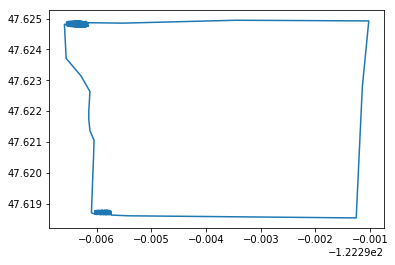

In [179]:
df = pd.read_csv('Data/gps_data.csv').filter(items=['X','Y','time'])

#print df.head()

plt.plot(df['X'],df['Y'])

Number of Clusters: 3
[0.6825845913595743, 0.3691280799450376, 0.42739846122492064]
[0.6336565069990694, 0.7259821140679871, 0.2815023402372666]
[0.3333860348855062, 0.22332986160842527, 0.4244015600961609]


Text(0.5,0,u'Time')

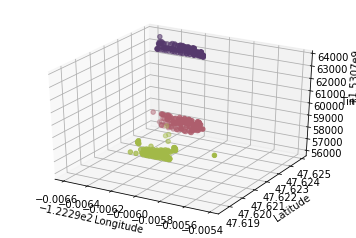

In [180]:
clusters = findClusters(df)
num_clusters = len(clusters)
print 'Number of Clusters: '+str(num_clusters)

cluster_centers = []

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0, num_clusters):
    color = [c[0] for c in np.random.rand(3,1)]
    print color
    cluster_df = pd.DataFrame(data=clusters[i], columns=['X','Y','time'])
    cluster_centers.append([np.mean(cluster_df['X']),np.mean(cluster_df['Y'])])
    ax.scatter(cluster_df['X'],cluster_df['Y'], cluster_df['time'], c=color)
    #plt.plot(cluster_df['X'],cluster_df['Y'],c=color)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')

In [181]:
centroid_place_data = []
for i in range(0, len(cluster_centers)):
    json_data = findPlaces(lat=cluster_centers[i][0],lon=cluster_centers[i][1],limit=5,radius=100)
    #print json.dumps(json_data, indent=4, sort_keys=True)
    parsed = parseJSON(json_data)
    centroid_place_data.append(parsed)
print centroid_place_data

[[[u"Rover's | LUC Office", u'2804 II E Madison', u'Seattle'], [u'2800 E. Madison', u'2800 E Madison St', u'Seattle'], [u"Araya's Vegetarian Place", u'2808 E Madison St', u'Seattle'], [u'Hoa Salon', u'2900 E Madison St', u'Seattle'], [u'Madison Valley', None, u'Seattle']], [[u"Karen & Neil's Airbnb", None, u'Seattle'], [u'Homer Harris Park', u'2401 E Howell St.', u'Seattle'], [u'Madison Valley', None, u'Seattle'], [u'Madison Valley Stormwater Storage Facility', u'118 30th Ave E', u'Seattle'], [u'Wallgreens', None, u'Puyallup']], [[u"Rover's | LUC Office", u'2804 II E Madison', u'Seattle'], [u'2800 E. Madison', u'2800 E Madison St', u'Seattle'], [u"Araya's Vegetarian Place", u'2808 E Madison St', u'Seattle'], [u'Hoa Salon', u'2900 E Madison St', u'Seattle'], [u'Madison Valley', None, u'Seattle']]]
